In [1]:
import polars as pl
import polars.selectors as cs
import soccerdata as sd
import matplotlib.pyplot as plt
import sklearn as skl
import pandas as ps
import numpy as np
import pyarrow
import seaborn as sb

[01/02/26 10:02:49] INFO     No custom team name replacements found. You can configure these in       ]8;id=102692;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=769172;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_config.py#91\91]8;;\
                             C:\Users\User\soccerdata\config\teamname_replacements.json.                           

                    INFO     Custom league dict loaded from                                          ]8;id=132552;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_config.py\_config.py]8;;\:]8;id=316209;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_config.py#195\195]8;;\
                             C:\Users\User\soccerdata\config\league_dict.json.                                     

In [2]:
fbref = sd.FBref(seasons = "2025")

[01/02/26 10:02:50] INFO     Saving cached data to C:\Users\User\soccerdata\data\FBref               ]8;id=796987;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_common.py\_common.py]8;;\:]8;id=749840;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\soccerdata\_common.py#263\263]8;;\

In [3]:
s = fbref.read_player_season_stats(stat_type="standard")
s = s[s[(  'Playing Time',      'Min')]>900]
s1 = pl.from_pandas(s, include_index=True)
s1 = s1.filter(
    (pl.col("('born', '')") >= 1999))
progress = fbref.read_player_season_stats(stat_type="possession")
p1 = pl.from_pandas(progress, include_index=True)
passes = fbref.read_player_season_stats(stat_type="passing")
p2 = pl.from_pandas(passes, include_index=True)
creative = fbref.read_player_season_stats(stat_type="goal_shot_creation")
c1 = pl.from_pandas(creative, include_index=True)
defense = fbref.read_player_season_stats(stat_type="defense")
d1 = pl.from_pandas(defense, include_index=True)

S = s1.drop("season")
S = S.drop("('nation', '')")
S = S.drop("('born', '')")
S = S.drop("('age', '')")

S = S.drop([
    "('Playing Time', 'MP')",     
    "('Playing Time', 'Starts')",
    "('Playing Time', 'Min')"
])

D = d1.drop("season")
D = D.drop("('nation', '')")
D = D.drop("('born', '')")
D = D.drop("('age', '')")
D = D.drop("('90s', '')")

C = c1.drop("season")
C = C.drop("('nation', '')")
C = C.drop("('born', '')")
C = C.drop("('age', '')")
C = C.drop("('90s', '')")
C = C.drop("('SCA', 'SCA90')")
C = C.drop("('GCA', 'GCA90')")

P = p1.drop("season")
P = P.drop("('nation', '')")
P = P.drop("('born', '')")
P = P.drop("('age', '')")
P = P.drop("('90s', '')")

P2 = p2.drop("season")
P2 = P2.drop("('nation', '')")
P2 = P2.drop("('born', '')")
P2 = P2.drop("('age', '')")
P2 = P2.drop("('90s', '')")

all_player = S.join(P, on=["league", "team", "player"], how="inner", suffix="_progress")
all_player = all_player.join(C, on=["league", "team", "player"], how="inner", suffix="_creative")
all_player = all_player.join(D, on=["league", "team", "player"], how="inner", suffix="_defense")
all_player = all_player.join(P2, on=["league", "team", "player"], how="inner", suffix="_passes")
all_player = all_player.filter(
    (pl.col("('pos', '')").str.contains("MF")
     |
     (pl.col("('pos', '')").str.contains("FW"))
     ))
all_player = all_player.drop("('pos', '')")
all_player = all_player.drop("('pos', '')_defense")
all_player = all_player.drop("('pos', '')_passes")
all_player = all_player.drop("('pos', '')_creative")
all_player = all_player.drop("('pos', '')_progress")
all_player = all_player.drop(cs.matches(r"^\('Per 90 Minutes'.*"))
all_player = all_player.fill_nan(0.0)


                    WARNING  C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=433873;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=159665;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                   
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

[01/02/26 10:02:53] WARNING  C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=973880;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=818142;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\_common.py:145: UserWarning: Season id "2021" is                         
                             ambiguous: interpreting as "20-21"                                                    
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

[01/02/26 10:03:00] WARNING  C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=615193;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=148685;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                   
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

                    WARNING  C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=455914;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=151801;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\_common.py:145: UserWarning: Season id "2021" is                         
                             ambiguous: interpreting as "20-21"                                                    
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

[01/02/26 10:03:06] WARNING  C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=670350;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=612637;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                   
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

                    WARNING  C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=745381;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=287290;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\_common.py:145: UserWarning: Season id "2021" is                         
                             ambiguous: interpreting as "20-21"                                                    
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

[01/02/26 10:03:13] WARNING  C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=785992;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=932120;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                   
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

                    WARNING  C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=928822;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=471926;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\_common.py:145: UserWarning: Season id "2021" is                         
                             ambiguous: interpreting as "20-21"                                                    
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

[01/02/26 10:03:18] WARNING  C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=110998;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=772702;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\fbref.py:165: FutureWarning: The behavior of DataFrame                   
                             concatenation with empty or all-NA entries is deprecated. In a future                 
                             version, this will no longer exclude empty or all-NA columns when                     
                             determining the result dtypes. To retain the old behavior, exclude the                
                             relevant entries before the concat operation.                                         
                               pd.concat(dfs)                                                                      
                                                                                                                   

                    WARNING  C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-package ]8;id=218377;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py\warnings.py]8;;\:]8;id=87247;file://C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\warnings.py#112\112]8;;\
                             s\soccerdata\_common.py:145: UserWarning: Season id "2021" is                         
                             ambiguous: interpreting as "20-21"                                                    
                               warnings.warn(msg, stacklevel=1)                                                    
                                                                                                                   

In [4]:
s.columns

MultiIndex([(        'nation',         ''),
            (           'pos',         ''),
            (           'age',         ''),
            (          'born',         ''),
            (  'Playing Time',       'MP'),
            (  'Playing Time',   'Starts'),
            (  'Playing Time',      'Min'),
            (  'Playing Time',      '90s'),
            (   'Performance',      'Gls'),
            (   'Performance',      'Ast'),
            (   'Performance',      'G+A'),
            (   'Performance',     'G-PK'),
            (   'Performance',       'PK'),
            (   'Performance',    'PKatt'),
            (   'Performance',     'CrdY'),
            (   'Performance',     'CrdR'),
            (      'Expected',       'xG'),
            (      'Expected',     'npxG'),
            (      'Expected',      'xAG'),
            (      'Expected', 'npxG+xAG'),
            (   'Progression',     'PrgC'),
            (   'Progression',     'PrgP'),
            (   'Progression',  

In [5]:
exclude_cols = ["born", "season", "league", "team", "player"]

numeric_cols_all = all_player.select(cs.numeric().exclude(exclude_cols)).columns

cols_to_normalize = [
    c for c in numeric_cols_all 
    if "90s" not in c 
    and "%" not in c 
    and "Pct" not in c
]

all_player = all_player.with_columns([
    (pl.col(col_name) / pl.col("('Playing Time', '90s')")).alias(col_name)
    for col_name in cols_to_normalize
])

all_player = all_player.fill_nan(0.0).fill_null(0.0).with_columns([
    pl.when(pl.col(col_name).is_infinite())
      .then(0.0)
      .otherwise(pl.col(col_name))
      .alias(col_name)
    for col_name in numeric_cols_all
])

In [6]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

identifier_cols = ["league", "team", "player"]
numeric_data = all_player.select(pl.col(pl.Float64, pl.Int64))

X_filtered = numeric_data.fill_null(0).to_numpy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_scaled)
labels = kmeans.labels_

all_players_with_clusters = all_player. with_columns(
    pl.Series(name="cluster", values=labels)
)

new = all_players_with_clusters.select(["player", "team", "cluster"]).filter(pl.col("player") == "Amad Diallo")
num = new.get_column("cluster")
target = all_players_with_clusters.filter(pl.col('cluster') == num)

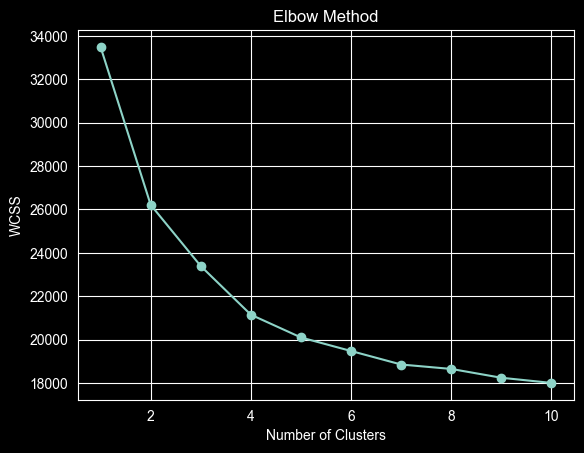

In [7]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

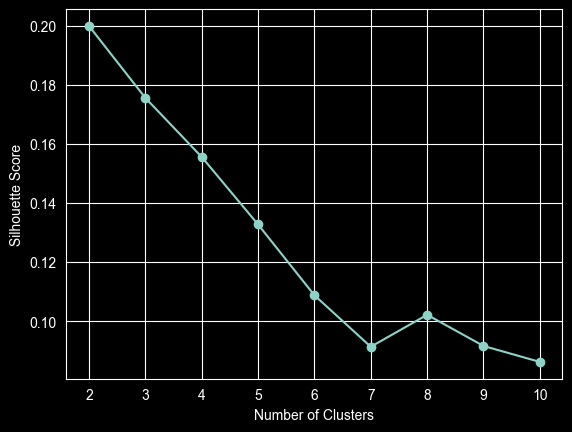

In [8]:
from sklearn.metrics import silhouette_score

scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    scores.append(silhouette_score(X_scaled, labels))

plt.plot(range(2, 11), scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [9]:
all_player.columns

['league',
 'team',
 'player',
 "('Playing Time', '90s')",
 "('Performance', 'Gls')",
 "('Performance', 'Ast')",
 "('Performance', 'G+A')",
 "('Performance', 'G-PK')",
 "('Performance', 'PK')",
 "('Performance', 'PKatt')",
 "('Performance', 'CrdY')",
 "('Performance', 'CrdR')",
 "('Expected', 'xG')",
 "('Expected', 'npxG')",
 "('Expected', 'xAG')",
 "('Expected', 'npxG+xAG')",
 "('Progression', 'PrgC')",
 "('Progression', 'PrgP')",
 "('Progression', 'PrgR')",
 "('Touches', 'Touches')",
 "('Touches', 'Def Pen')",
 "('Touches', 'Def 3rd')",
 "('Touches', 'Mid 3rd')",
 "('Touches', 'Att 3rd')",
 "('Touches', 'Att Pen')",
 "('Touches', 'Live')",
 "('Take-Ons', 'Att')",
 "('Take-Ons', 'Succ')",
 "('Take-Ons', 'Succ%')",
 "('Take-Ons', 'Tkld')",
 "('Take-Ons', 'Tkld%')",
 "('Carries', 'Carries')",
 "('Carries', 'TotDist')",
 "('Carries', 'PrgDist')",
 "('Carries', 'PrgC')",
 "('Carries', '1/3')",
 "('Carries', 'CPA')",
 "('Carries', 'Mis')",
 "('Carries', 'Dis')",
 "('Receiving', 'Rec')",
 "

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

target_cluster_id = num
identifier_cols = ["league", "team", "player"]

WG_Profile = target[["league", "team", "player",
"('Progression', 'PrgC')",
 "('Performance', 'CrdY')",
  "('Take-Ons', 'Att')",
 "('Take-Ons', 'Succ')",
 "('Take-Ons', 'Succ%')",
 "('Carries', 'TotDist')",
 "('Carries', 'PrgDist')",
"('Tackles', 'Tkl')",
"('Challenges', 'Tkl')",
"('Challenges', 'Tkl%')",
]]

nums = WG_Profile.select(pl.col(pl.Float64, pl.Int64))
print(f"Sub-clustering {WG_Profile.height} players from Cluster {target_cluster_id}...")

scaler_sub = StandardScaler()
X_sub_scaled = scaler_sub.fit_transform(nums)

kmeans_sub = KMeans(n_clusters=3, random_state=42)
sub_labels = kmeans_sub.fit_predict(X_sub_scaled)
sub_centroids = kmeans_sub.cluster_centers_

WG = WG_Profile.with_columns(
    pl.Series(name="sub_cluster", values=sub_labels)
)

Sub-clustering 177 players from Cluster shape: (1,)
Series: 'cluster' [i32]
[
	0
]...


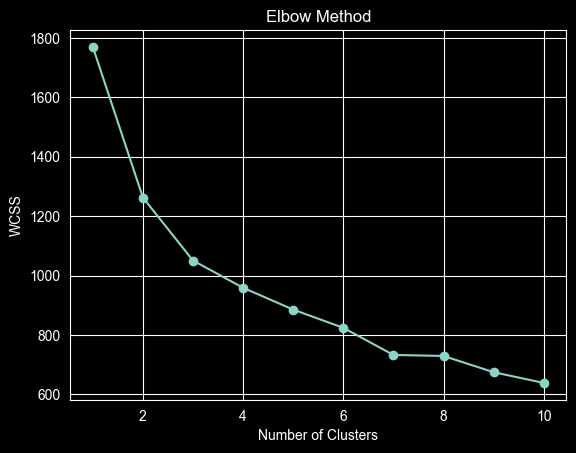

In [11]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_sub_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

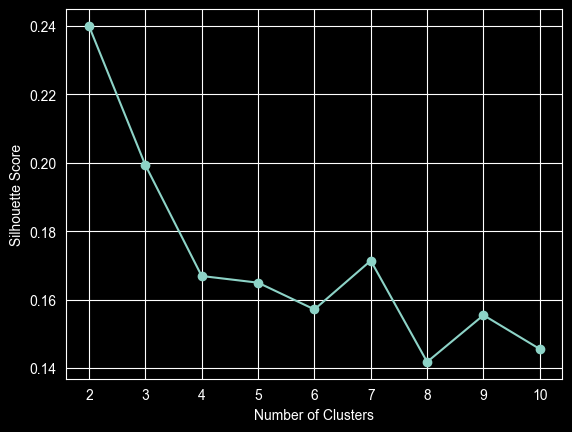

In [12]:
from sklearn.metrics import silhouette_score

scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_sub_scaled)
    scores.append(silhouette_score(X_sub_scaled, labels))

plt.plot(range(2, 11), scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [13]:
new = WG.select(["player", "team", "sub_cluster"]).filter(pl.col("player") == "Amad Diallo")
num = new.get_column("sub_cluster")
new
new2 = WG.select(["player", "team", "sub_cluster"]).filter(pl.col("sub_cluster") == num)
new2

player,team,sub_cluster
str,str,i32
"""Ephron Mason-Clark""","""Coventry City""",0
"""Jack Clarke""","""Ipswich Town""",0
"""Abdul Fatawu Issahaku""","""Leicester City""",0
"""Tom Fellows""","""Southampton""",0
"""Million Manhoef""","""Stoke City""",0
…,…,…
"""Ismael Saibari""","""PSV Eindhoven""",0
"""Mitchell van Bergen""","""Sparta R'dam""",0
"""Babatunde Akinsola""","""AVS Futebol""",0


In [14]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

amad_idx = WG.with_row_index().filter(pl.col("player") == "Amad Diallo").select("index").item()
amad_scaled = X_sub_scaled[amad_idx].reshape(1, -1)

In [15]:
distances = pairwise_distances(X_sub_scaled, amad_scaled, metric='cosine')

X_closest = 20

closest_indices = np.argsort(distances[:, 0])[:X_closest]

similar_players = WG[closest_indices].select(["player", "team"])
with pl.Config(tbl_rows=-1):
    print(similar_players)

shape: (20, 2)
┌────────────────────────┬─────────────────┐
│ player                 ┆ team            │
│ ---                    ┆ ---             │
│ str                    ┆ str             │
╞════════════════════════╪═════════════════╡
│ Amad Diallo            ┆ Manchester Utd  │
│ Bukayo Saka            ┆ Arsenal         │
│ Tom Fellows            ┆ Southampton     │
│ Yankuba Minteh         ┆ Brighton        │
│ Maxence Rivera         ┆ Heerenveen      │
│ Oscar Gloukh           ┆ Ajax            │
│ Jeremy Doku            ┆ Manchester City │
│ Anis Hadj Moussa       ┆ Feyenoord       │
│ Jaden Philogene Bidace ┆ Ipswich Town    │
│ Vinicius Júnior        ┆ Real Madrid     │
│ Leo Sauer              ┆ Feyenoord       │
│ Michael Johnston       ┆ West Brom       │
│ Ismael Saibari         ┆ PSV Eindhoven   │
│ Bazoumana Touré        ┆ Hoffenheim      │
│ Mika Godts             ┆ Ajax            │
│ Jack Clarke            ┆ Ipswich Town    │
│ Juho Talvitie          ┆ NAC Breda    